In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
import math

This notebook assumes you have completed the notebook [Introduction of sine waves](TDS_Introduction-sine_waves.ipynb). This notebook follows the same pattern of time domain waveform generation: instantaneous frequency -> phase step -> total phase -> time domain waveform. 

Our goal is to track features of different acoustic impedance in material using a low power time domain waveform. Time delay spectrometry (TDS) is one implementation of this goal. To understand TDS we need to understand the waveform which is used by TDS called a chirp. A chirp is a sinusoid that is constantly varying in frequency. The chirp is generated by integrating a varying phase step which is derived from an instantaneous frequency profile. We will generate a chirp in this notebook.
The phase of the chirp can be found by integrating the instantaneous frequency:

\begin{equation}
	f(t)=\frac{f_{end}-f_{start}}{T_c}t + f_{start}
\end{equation}

\begin{equation}
\Delta\phi(t) = 2\pi f(t)\Delta t
\end{equation}

\begin{equation}
\phi (t)=\int_{}^{} \Delta\phi(t) = \int_{}^{} 2\pi f(t) dt = \int_{}^{}\frac{f_{end}-f_{start}}{T_c}tdt + \int_{}^{}f_{start}dt
\end{equation}

\begin{equation}
 \phi (t)= \frac{f_{end}-f_{start}}{T_c}\int_{}^{}tdt + f_{start}\int_{}^{}dt
\end{equation}

\begin{equation}
 \phi (t)= \frac{f_{end}-f_{start}}{T_c}\frac{t^2}{2} + f_{start}t
\end{equation}

This gives the time series value of

\begin{equation}
x(t) = e^{j\phi (t)} = e^{j(\frac{f_{end}-f_{start}}{T_c}\frac{t^2}{2} + f_{start}t)} 
\end{equation}

But the formula for phase requires squaring time which will cause numeric errors as the time increases. Another approach is to implement the formula for phase as a cummulative summation. 

\begin{equation}
\phi_{sum} (N)=\sum_{k=1}^{N} \Delta\phi(k) = \sum_{k=1}^{N} 2\pi f(k) t_s = \sum_{k=1}^{N}(\frac{f_{end}-f_{start}}{T_c}k + f_{start})t_s
\end{equation}


This allow for the phase always stay between 0 and two pi by subtracting two phi whenever the phase exceeds the value. We will work with the cummlative sum of phase, but then compare it to the integral to determine how accurate the cummulative sum is.



In [17]:
#max free 8 points per sample

#Tc is the max depth we are interested in
Tc_sec=5

f_start_Hz=3000
#talk about difference and similarity of sine wave example, answer why not 32 samples
f_stop_Hz=20000

#sample rate
fs=44100
samplesPerCycle=fs/f_stop_Hz
ts=1/fs

total_samples= math.ceil(fs*Tc_sec)
n = np.arange(0,total_samples, step=1, dtype=np.float64)
t_sec=n*ts
t_usec = t_sec *1e6

#This is the frequency of the chirp over time. We assume linear change in frequency
chirp_freq_slope_HzPerSec=(f_stop_Hz-f_start_Hz)/Tc_sec

#Compute the instantaneous frequency which is a linear function
chirp_instantaneous_freq_Hz=chirp_freq_slope_HzPerSec*t_sec+f_start_Hz
chirp_instantaneous_angular_freq_radPerSec=2*np.pi*chirp_instantaneous_freq_Hz

#Since frequency is a change in phase the we can plot it as a phase step
chirp_phase_step_rad=chirp_instantaneous_angular_freq_radPerSec*ts

#The phase step can be summed (or integrated) to produce the total phase which is the phase value 
#for each point in time for the chirp function
chirp_phase_rad=np.cumsum(chirp_phase_step_rad)
#The time domain chirp function
chirp = np.exp(1j*chirp_phase_rad)

In [16]:
def calc_chirp_phase_step(f_start_Hz, f_stop_Hz, Tc_sec,fs):
    ts=1/fs
    total_samples= math.ceil(fs*Tc_sec)
    n = np.arange(0,total_samples, step=(total_samples-1), dtype=np.float64)
    t_sec=n*ts

    #This is the frequency of the chirp over time. We assume linear change in frequency
    chirp_freq_slope_HzPerSec=(f_stop_Hz-f_start_Hz)/Tc_sec

    #Compute the instantaneous frequency which is a linear function
    chirp_instantaneous_freq_Hz=chirp_freq_slope_HzPerSec*t_sec+f_start_Hz
    chirp_instantaneous_angular_freq_radPerSec=2*np.pi*chirp_instantaneous_freq_Hz

    #Since frequency is a change in phase the we can plot it as a phase step
    chirp_phase_step_rad=chirp_instantaneous_angular_freq_radPerSec*ts
    return chirp_phase_step_rad

chirp_phase_step_rad=calc_chirp_phase_step(f_start_Hz, f_stop_Hz, Tc_sec,fs)
print(f'chirp_phase_step_rad[0] = {chirp_phase_step_rad[0]} rad and the end is chirp_phase_step_rad[-1] = {chirp_phase_step_rad[-1]}')
print(f'amplitude = {chirp_phase_step_rad[-1] - chirp_phase_step_rad[0]} rad')
print(f'offset = {(chirp_phase_step_rad[-1] - chirp_phase_step_rad[0])/2+chirp_phase_step_rad[0]} rad')


chirp_phase_step_rad[0] = 0.42742757191697867 rad and the end is chirp_phase_step_rad[-1] = 2.8495061615799755
amplitude = 2.4220785896629966 rad
offset = 1.638466866748477 rad


<IPython.core.display.Javascript object>


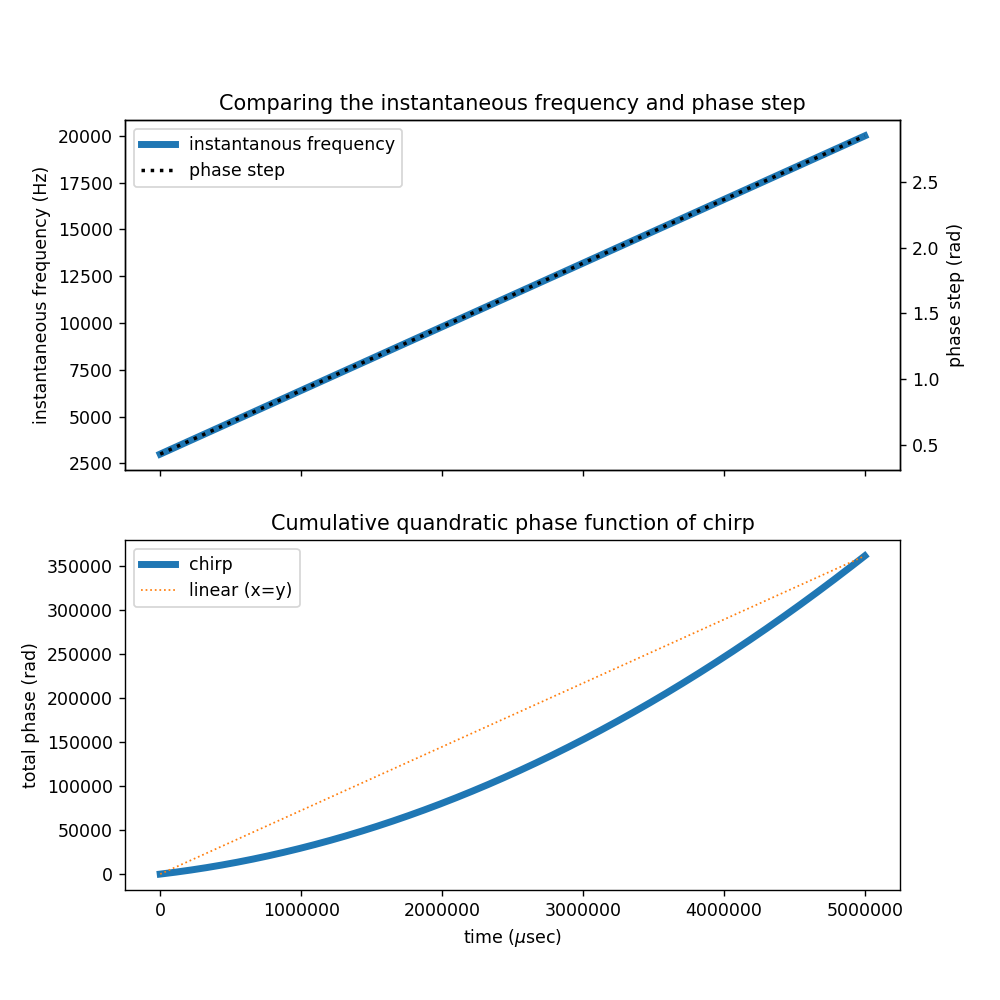

In [18]:
#We can see, unlike the complex exponential, the chirp's instantaneous frequency is linearly increasing. 
#This corresponds with the linearly increasing phase step. 
fig, ax = plt.subplots(2, 1, sharex=True,figsize = [8, 8])
lns1=ax[0].plot(t_usec,chirp_instantaneous_freq_Hz,linewidth=4, label='instantanous frequency');
ax[0].set_title('Comparing the instantaneous frequency and phase step')
ax[0].set_ylabel('instantaneous frequency (Hz)')

axt = ax[0].twinx()
lns2=axt.plot(t_usec,chirp_phase_step_rad,linewidth=2,color='black', linestyle=':', label='phase step');
axt.set_ylabel('phase step (rad)')

#ref: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0].legend(lns, labs, loc=0)

#We see that summing or integrating the linearly increasing phase step gives a quadratic function of total phase.
ax[1].plot(t_usec,chirp_phase_rad,linewidth=4,label='chirp');
ax[1].plot([t_usec[0], t_usec[-1]],[chirp_phase_rad[0], chirp_phase_rad[-1]],linewidth=1, linestyle=':',label='linear (x=y)');
ax[1].set_title('Cumulative quandratic phase function of chirp')
ax[1].set_xlabel('time ($\mu$sec)')
ax[1].set_ylabel('total phase (rad)')
ax[1].legend();



In [12]:
print(f'chirp_phase_step_rad[0] = {chirp_phase_step_rad[0]} rad and the end is chirp_phase_step_rad[-1] = {chirp_phase_step_rad[-1]}')
print(f'amplitude = {chirp_phase_step_rad[-1] - chirp_phase_step_rad[0]} rad')
print(f'offset = {(chirp_phase_step_rad[-1] - chirp_phase_step_rad[0])/2+chirp_phase_step_rad[0]} rad')

chirp_phase_step_rad[0] = 0.42742757191697867 rad and the end is chirp_phase_step_rad[-1] = 2.8495061615799755
amplitude = 2.4220785896629966 rad
offset = 1.638466866748477 rad
